In [192]:
%load_ext autoreload
%autoreload 2
import numpy as np
from qutip import *
import scipy.optimize
from matplotlib import pyplot as plt

import cavity_qed_systems
import pulse
import cmps_utils
import tncontract as tn
import parameterized_pulse as ppulse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
def optimize_overlap(state, target_mps, pulse):
    """Right now we assume that there is only one pulse."""
    def _obj_fun(x):
        pulse.update(x)
        olap = np.abs(state.get_inner_product(target_mps, [pulse]))**2
        print("Current overlap = ", olap)
        return -olap
    
    def _gradient(x):
        pulse.update(x)
        inner_prod = state.get_inner_product(target_mps, [pulse])
        grad_inner_prod = state.get_inner_prod_gradient(
            target_mps, [pulse])[0]
        grad = -2 * pulse.get_gradient(state.times) @ np.real(
            grad_inner_prod * np.conj(inner_prod))
        #print(np.shape(grad))
        return grad.astype(float)

    print(pulse.bounds())
    print(np.shape(pulse.state()))
    scipy.optimize.minimize(
        _obj_fun, pulse.state(), bounds=pulse.bounds(),jac=_gradient, method="L-BFGS-B") # jac=_gradient,

[[-1.  1.]
 [-1.  1.]
 [-1.  1.]
 ...
 [-1.  1.]
 [-1.  1.]
 [-1.  1.]]
(2001,)
Current overlap =  0.0417378718074585


<ipython-input-193-1df31013740c>:17: ComplexWarning: Casting complex values to real discards the imaginary part
  return grad.astype(float)


Current overlap =  0.041738524955741506
Current overlap =  0.041739179342290864
Current overlap =  0.041741803059201145
Current overlap =  0.04175239663731658
Current overlap =  0.04175319426547225
Current overlap =  0.041753875822475965
Current overlap =  0.04175660858983189
Current overlap =  0.041767644265695264
Current overlap =  0.0418021806014637
Current overlap =  0.04180295766238167
Current overlap =  0.04180607375275056
Current overlap =  0.04181866363027506
Current overlap =  0.04187102936758606
Current overlap =  0.041871029415927574
Current overlap =  0.041871947229693264
Current overlap =  0.04187562825219153
Current overlap =  0.04189050857622885
Current overlap =  0.0419525266835689
Current overlap =  0.042064422786260325
Current overlap =  0.04206576127514382
Current overlap =  0.04207113067967046
Current overlap =  0.042086970107712736
Current overlap =  0.0420883603776363
Current overlap =  0.04209393760970255
Current overlap =  0.04211650486818679
Current overlap =  

Current overlap =  0.05361525554206359
Current overlap =  0.053640173513294725
Current overlap =  0.053740055357553725
Current overlap =  0.05414291661556105
Current overlap =  0.05414767907343399
Current overlap =  0.054173480395594276
Current overlap =  0.05427689862244481
Current overlap =  0.05434199171775873
Current overlap =  0.05436811264260456
Current overlap =  0.054472810262542935
Current overlap =  0.05486096040331935
Current overlap =  0.05488791481174051
Current overlap =  0.05499594866021649
Current overlap =  0.05510516704906635
Current overlap =  0.055132439048673626
Current overlap =  0.05513424685971033
Current overlap =  0.05516156406830787
Current overlap =  0.055173523522644694
Current overlap =  0.05520090072986877
Current overlap =  0.05521343978949844
Current overlap =  0.05524082166525569
Current overlap =  0.055350564707396306
Current overlap =  0.05538811093450582
Current overlap =  0.05541569989470271
Current overlap =  0.05552627114428279
Current overlap = 

Current overlap =  0.08163941031541574
Current overlap =  0.08179518211061793
Current overlap =  0.08183906390017721
Current overlap =  0.08201462061988883
Current overlap =  0.08213494855353454
Current overlap =  0.0821788559564018
Current overlap =  0.08235451239448897
Current overlap =  0.08246618821793227
Current overlap =  0.0825100945422109
Current overlap =  0.08268574434301018
Current overlap =  0.08288939358207337
Current overlap =  0.08293327450278581
Current overlap =  0.08310881944679685
Current overlap =  0.08327552529752381
Current overlap =  0.08331940092398256
Current overlap =  0.0834232438344751
Current overlap =  0.08346712310604715
Current overlap =  0.08364265791260606
Current overlap =  0.08380029540674784
Current overlap =  0.083844139575185
Current overlap =  0.08401953104319408
Current overlap =  0.08416569752785269
Current overlap =  0.08420949871058393
Current overlap =  0.08438471606910686
Current overlap =  0.08445681975150818
Current overlap =  0.084500638

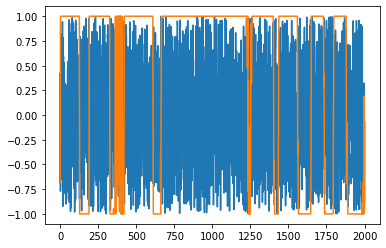

In [613]:
targetState2 = cavity_qed_systems.ModulatedTavisCumming(0.01, 2000, [0,0], 0.5, 0.5)
targetMPS2 = targetState2.get_mps([pulse.ConstantPulse(0)])
state2 = cavity_qed_systems.ModulatedTavisCumming(0.01, 2000, [-1,1], 0.5, 0.5)
delta2 = ppulse.DirectParameterizedPulse(20, 2000, [-1, 1])
plt.plot(delta2.state())
optimize_overlap(state2, targetMPS2, delta2)
plt.plot(delta2.state())

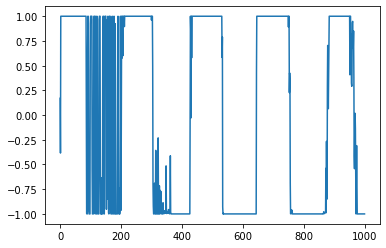

In [335]:
plt.plot(delta2.state())

In [195]:
def G2_shift(G2):
    #t is first index, tau is second index
    shape = np.shape(G2)
    G2_shifted = np.zeros(shape, dtype = 'complex')
    for t_ind in range(shape[0]):
        G2_shifted[t_ind, t_ind:] = G2[t_ind, 0:(shape[-1]-t_ind)]
    return G2_shifted
    

In [700]:
#pulseTune = delta2 
pulseTune = pulse.ConstantPulse(0)

def tuningPulse(t, args):
    return pulseTune(t)

N = 3    #number cavity levels

detuning0 = -1
detuning1 = 1
g = 0.25
gamma_c = 0.5

sm0 = tensor(destroy(2), qeye(2), qeye(N))     # atomic lowering operator 0
sm1 = tensor(qeye(2), destroy(2), qeye(N))     # atomic lowering operator 1
cavLower = tensor(qeye(2), qeye(2), destroy(N))

H0 = sm0.dag()*sm0*detuning0 + sm1.dag()*sm1*detuning1
H_tc = g * (sm0*cavLower.dag() + sm0.dag()*cavLower + sm1*cavLower.dag() + sm1.dag()*cavLower)

#H_stark = tensor(fock(2,1)*fock(2,1).dag(), fock(2,1)*fock(2,1).dag(), qeye(N))

H_stark = cavLower.dag()*cavLower

H = [H0 + H_tc, [H_stark, tuningPulse]]

# collapse operator that describes dissipation
c_ops = [np.sqrt(gamma_c) * cavLower]  # represents cavity emission

#H_stark = tensor(fock(2,1)*fock(2,1).dag(), fock(2,1)*fock(2,1).dag(), qeye(N))

rho0 = tensor(fock(2,1), fock(2,1), fock(N,0))

zeroState = tensor(fock(2,0), fock(2,0), fock(N,0))

In [701]:
tlist = np.linspace(0,20,500)
taulist = np.linspace(0,20,500)

G2 = correlation_4op_2t(H, rho0, tlist, taulist, c_ops, cavLower.dag(), cavLower.dag(), cavLower, cavLower, solver='me', args={})

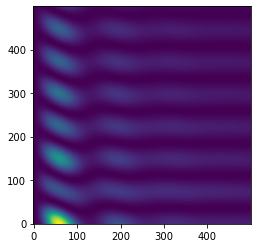

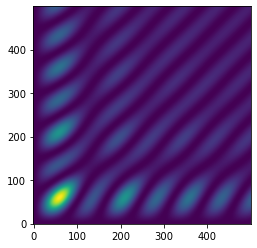

In [702]:
plt.imshow(np.abs(G2.T), origin = 'lower')
plt.show()
G2_shifted = G2_shift(G2) + np.tril(G2_shift(G2).T,-1)
plt.imshow(np.abs(G2_shifted.T), origin = 'lower')
plt.show()

In [682]:
T = 150
tlist = np.linspace(0,20,T)

scattered_state = temporal_scattered_state(H, rho0, 2, c_ops, tlist, zeroState)

correlations = np.zeros((T, T), dtype = 'complex')

for i in range(T):
    for j in range(T):
        # temporal_scattered_state() computes only using ordered emission times, so to  
        # get the full set of correlations, we need to use ordered temporal basis vector
        [a,b] = sorted([i,j])
        basis_vec = temporal_basis_vector([[a,b]], T)
        correlations[i,j] = ((basis_vec.dag() * scattered_state).full().item())

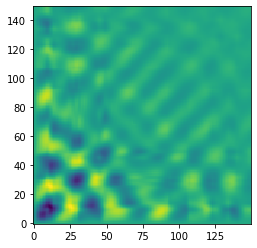

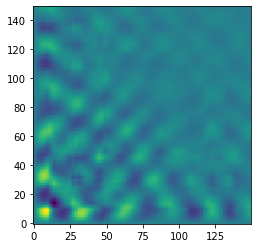

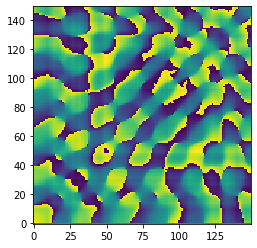

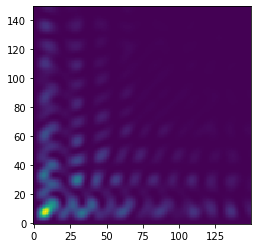

In [683]:
plt.imshow(np.real(correlations), interpolation='nearest', origin='lower')
plt.show()
plt.imshow(np.imag(correlations), interpolation='nearest', origin='lower')
plt.show()
plt.imshow(np.angle(correlations), interpolation='nearest', origin='lower')
plt.show()
plt.imshow(np.abs(correlations)**2, interpolation='nearest', origin='lower')
plt.show()

In [165]:
perfG2 = G2

In [169]:
detunedG2 = G2

In [173]:
pulsedG2 = G2

In [179]:
norm = np.sum(np.sum(perfG2*np.conj(perfG2)))
print(norm)
normDetuneed = np.sum(np.sum(perfG2*np.conj(detunedG2)))
print(normDetuneed)
pulseDetuneed = np.sum(np.sum(perfG2*np.conj(pulsedG2)))
print(pulseDetuneed)

(68.82196486147957+0j)
(13.2656486239799+0j)
(11.723340242737642+0j)


In [180]:
np.min(np.min(G2))

(-3.7072586261990245e-07+0j)

In [181]:
np.max(np.max(G2))

(0.25002477367070924+0j)

In [182]:
13.26/69

0.19217391304347825

In [620]:
perfCor = correlations

In [684]:
correctedCor = correlations

In [626]:
uncorrectedCorr = correlations

In [458]:
np.abs(np.sum(np.sum(perfCor*np.conj(correctedCor))))

0.4507624046945407

In [491]:
np.abs(np.sum(np.sum(perfCor*np.conj(perfCor))))

303.0435886604143

In [569]:
np.abs(np.sum(np.sum(perfCor*np.conj(uncorrectedCorr))))

21.143410390516603

In [276]:
3.7468/11.78

0.31806451612903225

In [379]:
3.586/12 

0.29883333333333334

In [380]:
4.89/12

0.4075

In [485]:
7.555/108

0.0699537037037037

In [486]:
(7.555/108)**2

0.004893520661865569

In [524]:
(6.52/303.04)**2

0.0004629086293737015

In [526]:
(21/303.04)**2

0.004802182655392619

In [687]:
targetState2 = cavity_qed_systems.ModulatedTavisCumming(0.001, 20000, [0,0], 1, 0.5)
targetMPS2 = targetState2.get_mps([pulse.ConstantPulse(0)])
state2 = cavity_qed_systems.ModulatedTavisCumming(0.001, 20000, [-1,1], 1, 0.5)
print(np.abs(state2.get_inner_product(targetMPS2, [pulse.ConstantPulse(0)]))**2)
print(np.abs(state2.get_inner_product(targetMPS2, [delta2]))**2)
print(np.abs(targetState2.get_inner_product(targetMPS2, [pulse.ConstantPulse(0)]))**2)
#print((state2.get_inner_product(targetMPS2, [pulse.ConstantPulse(0)])))


0.051594507999561466
0.18630246832785644
0.9834906265388489


In [513]:
0.051/0.983

0.05188199389623601

In [533]:
np.abs(np.sum(np.sum(perfCor*np.conj(uncorrectedCorr))))**2/np.abs(np.sum(np.sum(perfCor*np.conj(perfCor))))**2

0.004867880163834494

In [551]:
np.abs(np.sum(np.sum(perfCor*np.conj(uncorrectedCorr))))**2/np.abs(np.sum(np.sum(perfCor*np.conj(perfCor))))**2

0.9622991322888257

In [641]:
np.abs(np.sum(np.sum(perfCor*np.conj(uncorrectedCorr))))**2/np.abs(np.sum(np.sum(perfCor*np.conj(perfCor))))**2

0.05462151311908174

In [685]:
np.abs(np.sum(np.sum(perfCor*np.conj(correctedCor))))**2/np.abs(np.sum(np.sum(perfCor*np.conj(perfCor))))**2

0.18737274017087927

In [628]:
(np.sum(np.sum(perfCor*np.conj(uncorrectedCorr))))/np.abs(np.sum(np.sum(perfCor*np.conj(perfCor))))

(0.2337124582025565+0j)

ValueError: setting an array element with a sequence.

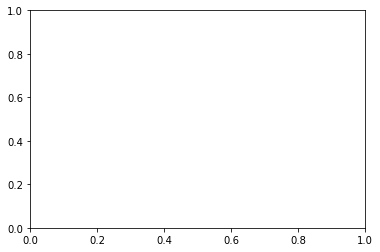

In [573]:
targetState2 = cavity_qed_systems.ModulatedTavisCumming(0.01, 2000, [0,0], 0.5, 0.5)
targetMPS2 = targetState2.get_mps([pulse.ConstantPulse(0)])
state2 = cavity_qed_systems.ModulatedTavisCumming(0.01, 2000, [-1,1], 0.5, 0.5)

numExp = cmps_utils.compute_photon_number_exp(targetMPS2)

plt.plot(numExp)

<ipython-input-586-7d2a41004316>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  numExp2[i] = (numExp[i].data)


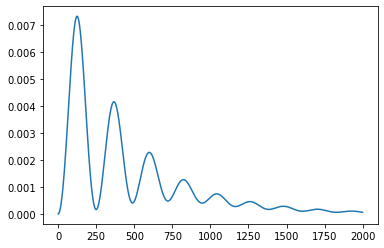

In [586]:
numExp2 = np.zeros(np.shape(numExp))

for i in range(len(numExp)):
    numExp2[i] = (numExp[i].data)

plt.plot(numExp2)

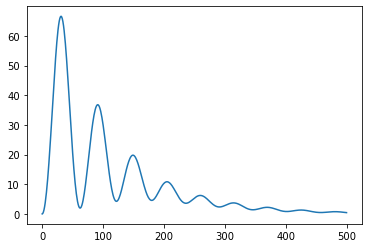

In [611]:
#print(np.sum(abs(G2.T), axis = 0))

plt.plot(np.sum(abs(G2_shifted), axis = 0))

<ipython-input-655-e7acb7f5774a>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  numExp2[i] = (numExp[i].data)


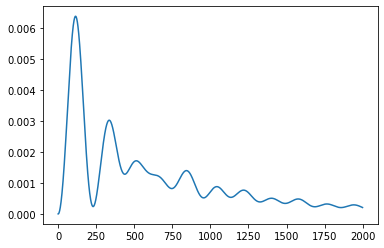

In [655]:
targetState2 = cavity_qed_systems.ModulatedTavisCumming(0.01, 2000, [0,0], 0.5, 0.5)
state2 = cavity_qed_systems.ModulatedTavisCumming(0.01, 2000, [-1,1], 0.5, 0.5)
MPS2 = state2.get_mps([pulse.ConstantPulse(0)])

numExp = cmps_utils.compute_photon_number_exp(MPS2)

numExp2 = np.zeros(np.shape(numExp))

for i in range(len(numExp)):
    numExp2[i] = (numExp[i].data)

plt.plot(numExp2)

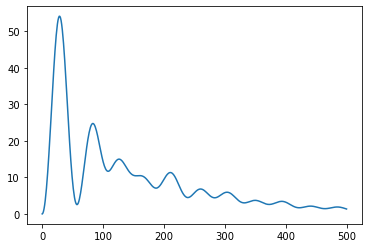

In [656]:
plt.plot(np.sum(abs(G2_shifted), axis = 0))

<ipython-input-661-03a67ffae429>:10: ComplexWarning: Casting complex values to real discards the imaginary part
  numExp2[i] = (numExp[i].data)


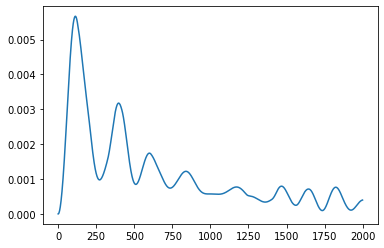

In [661]:
targetState2 = cavity_qed_systems.ModulatedTavisCumming(0.01, 2000, [0,0], 0.5, 0.5)
state2 = cavity_qed_systems.ModulatedTavisCumming(0.01, 2000, [-1,1], 0.5, 0.5)
MPS2 = state2.get_mps([delta2])

numExp = cmps_utils.compute_photon_number_exp(MPS2)

numExp2 = np.zeros(np.shape(numExp))

for i in range(len(numExp)):
    numExp2[i] = (numExp[i].data)

plt.plot(numExp2)

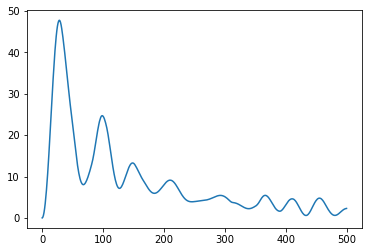

In [681]:
plt.plot(np.sum(abs(G2_shifted), axis = 0))